In [112]:
from projects.MTL.rs.SKMTEA.evaluation.qmri import QuantitativeKneeMRI
from dosma.scan_sequences import QDess
import dosma as dm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import h5py
import nibabel as nib
from typing import Union,Sequence
import numpy as np

In [113]:

def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs

In [114]:
fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/best/2024-04-08_15-19-06/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan = f['reconstruction'][()].squeeze()
    segmentations  = np.transpose(f['segmentation'][()].squeeze(),(0,2,3,1))
    target  = f['target_reconstruction'][()].squeeze()
    segmentation_labels  = np.transpose(f['target_segmentation'][()].squeeze(),(0,2,3,1))
    loglike  = f['intermediate_loglike'][()].squeeze()
    zero_filled  = f['zero_filled'][()].squeeze()
    inter_rec  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
print(scan.shape,segmentation_labels.shape,target.shape, loglike.shape,inter_rec.shape,zero_filled.shape,segmentations.shape)


segmentation_labels_affine = nib.load(
                "/data/projects/recon/data/public/multitask/skm-tea/v1-release/segmentation_masks/raw-data-track/MTR_005.nii.gz")


<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
(80, 2, 256, 208) (80, 256, 208, 5) (80, 2, 256, 208) (80, 2, 5, 2, 256, 208) (80, 2, 5, 2, 256, 208) (80, 2, 256, 208) (80, 256, 208, 5)


In [106]:


seg_pred = dm.MedicalVolume(segmentations[:,:,:,1:], affine=segmentation_labels_affine.affine)
seg_gt = dm.MedicalVolume(segmentation_labels[:,:,:,1:], affine=segmentation_labels_affine.affine)

echo1_gt = dm.MedicalVolume(target[:,0,:,:], affine=segmentation_labels_affine.affine)
echo2_gt = dm.MedicalVolume(target[:,1,:,:], affine=segmentation_labels_affine.affine)

echo1_pred = dm.MedicalVolume(scan[:,0,:,:], affine=segmentation_labels_affine.affine)
echo2_pred = dm.MedicalVolume(scan[:,1,:,:], affine=segmentation_labels_affine.affine)


In [107]:
metadata = pd.read_csv("/data/projects/recon/data/public/multitask/skm-tea/v1-release/all_metadata.csv")
metadata = metadata[metadata["MTR_ID"] == "MTR_005"]



In [108]:
def get_t1(seg: dm.MedicalVolume):
  """Build T1 maps based on the segmentation.

  `seg[..., 3]` should correspond to the meniscus segmentation map.

  Args:
    seg (dm.MedicalVolume): A one-hot encoded segmentation mask, where the
      last dimension is the channel dimension.

  Returns:
    dm.MedicalVolume: The estimated T1 map (in milliseconds).
  """
  t1 = dm.MedicalVolume(np.ones(seg.shape[:3]) * 1200, seg.affine).to(seg.device)
  t1[seg.A[..., 3].astype(bool)] = 1000
  return t1

t1_gt = get_t1(seg_gt)
t1_pred = get_t1(seg_pred)

In [109]:
def compute_t2_map(t1: dm.MedicalVolume):
  qdess = QDess([echo1_gt, echo2_gt]).to(t1.device)
  t2map = qdess.generate_t2_map(
      suppress_fat=True,
      suppress_fluid=True,
      gl_area=float(metadata["SpoilerGradientArea"]),
      tg=float(metadata["SpoilerGradientTime"]),
      tr=float(metadata["RepetitionTime"]),
      te=float(metadata["EchoTime1"]),
      alpha=float(metadata["FlipAngle"]),
      t1=t1,
      nan_bounds=(0, 100),
      nan_to_num=True,
  )
  return t2map.volumetric_map

def compute_t2_map_pred(t1: dm.MedicalVolume):
  qdess = QDess([echo1_pred, echo2_pred]).to(t1.device)
  t2map = qdess.generate_t2_map(
      suppress_fat=True,
      suppress_fluid=True,
      gl_area=float(metadata["SpoilerGradientArea"]),
      tg=float(metadata["SpoilerGradientTime"]),
      tr=float(metadata["RepetitionTime"]),
      te=float(metadata["EchoTime1"]),
      alpha=float(metadata["FlipAngle"]),
      t1=t1,
      nan_bounds=(0, 100),
      nan_to_num=True,
  )
  return t2map.volumetric_map
t2_gt = compute_t2_map(t1_gt)
t2_pred = compute_t2_map(t1_pred)

/home/tmpaquaij/tmp/ipykernel_83810/3997530731.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gl_area=float(metadata["SpoilerGradientArea"]),
/home/tmpaquaij/tmp/ipykernel_83810/3997530731.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tg=float(metadata["SpoilerGradientTime"]),
/home/tmpaquaij/tmp/ipykernel_83810/3997530731.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tr=float(metadata["RepetitionTime"]),
/home/tmpaquaij/tmp/ipykernel_83810/3997530731.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  te=float(metadata["EchoTime1"]),
/home/tmpaquaij/tmp/ipykernel_83810/3997530731

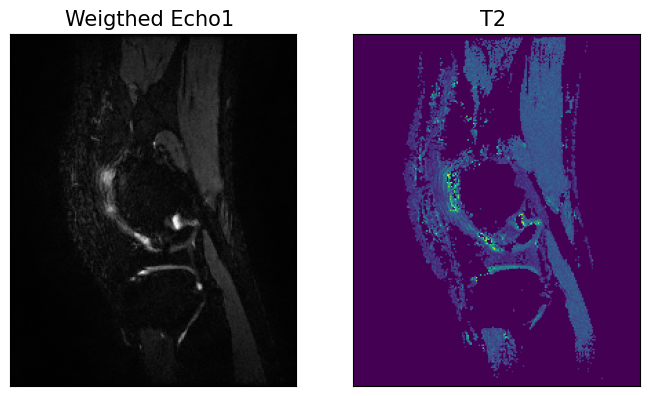

In [110]:
sl = 15 # Sagittal slice to plot
nrows = 1
hsize = 5
wsize = hsize / scan.shape[2] * scan.shape[3]
_, axs = plt.subplots(nrows, 2, figsize=(2 * wsize, nrows * hsize))
plot_images(
  [np.abs(scan)[sl,1,:,:],t2_gt.A[sl,:,:]],
  titles=["Weigthed Echo1 ", "T2 "],
  cmap=["gray","viridis"],axs=axs,fontsize=15
)
plt.savefig('/scratch/tmpaquaij/MasterProject/Figures/T2_prediction.png')

In [111]:
use_subregions = False
use_cpu = use_subregions  # computing subregions is currently limited to the CPU
tissues = ["pc", "fc", "tc", "men"]

qmri_gt = QuantitativeKneeMRI(channel_names=tissues, subregions=use_subregions, use_cpu=use_cpu)
qmri_pred = QuantitativeKneeMRI(channel_names=tissues, subregions=use_subregions, use_cpu=use_cpu)

# Reset the metrics
qmri_gt.reset()
qmri_pred.reset()

# Compute regional qMRI estimates using ground truth and predicted segmentations.
qmri_gt(ids=[scan["scan_id"]], quantitative_map=[t2_gt], sem_seg=[seg_gt], medial_direction=metadata["MedialDirection"])
qmri_pred(ids=[scan["scan_id"]], quantitative_map=[t2_pred], sem_seg=[seg_pred], medial_direction=metadata["MedialDirection"])

print("Ground Truth Regional T2 Estimates:")
display(qmri_gt.to_pandas())

print("Predicted Regional T2 Estimates:")
display(qmri_pred.to_pandas())

ValueError: Unexpected keyword arguments: `compute_on_step`